In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
import os
os.chdir(os.path.dirname(os.getcwd()))

In [1]:
from typing import *
from typing_extensions import *
from numpy.typing import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

import hcrot
from hcrot import layers

In [ ]:
class Model(layers.Module):
    def __init__(self):
        super().__init__()
        self.unet = layers.UNetModel(
            sample_size=14,
            in_channels=1,
            out_channels=1,
            block_out_channels=(32,64,32),
            num_class_embeds=10,
        )

    def forward(self, x_noisy, t, labels):
        noise_pred = self.unet(x_noisy, t, labels)
        return noise_pred

In [ ]:
batch_size = 512
num_epochs = 10
timesteps = 1000
lr = 1e-4

def average_pooling(img, pool_size=2):
    B, C, H, W = img.shape
    new_H, new_W = H // pool_size, W // pool_size
    img = img[:,:,:new_H * pool_size, :new_W * pool_size]
    img_reshaped = img.reshape(B, C, new_H, pool_size, new_W, pool_size)
    downsampled = img_reshaped.mean(axis=(3, 5))
    return downsampled

# MNIST 데이터 로드
df = pd.read_csv('./datasets/mnist_test.csv')
label = df['7'].to_numpy()
df = df.drop('7',axis=1)
dat = df.to_numpy()

mnist = dat[:batch_size * 10]
train_label = label[:batch_size * 10]
mnist = mnist.reshape(-1,1,28,28).astype(np.float32)
mnist = (mnist / 255.) * 2. - 1.
mnist = average_pooling(mnist, 2) # resize
dataloader = hcrot.dataset.Dataloader(mnist, train_label, batch_size=batch_size, shuffle=True)

# Model, Optimizer, Loss
model = Model()
# model.load_state_dict(hcrot.utils.load('datasets/artifact.pkl'))
optimizer = hcrot.optim.AdamW(model, lr_rate=lr)
criterion = layers.MSELoss()

noise_scheduler = layers.DDPMScheduler(num_train_timesteps=timesteps, beta_schedule="squaredcos_cap_v2")

pbar = trange(num_epochs)
for epoch in pbar:
    total_loss = 0
    for i, (x, label) in enumerate(dataloader):
        timestep = np.random.randint(0, timesteps, (x.shape[0],))
        # x_noisy, noise = q_sample(x, t)

        noise = np.random.randn(*x.shape)
        noisy_x = noise_scheduler.add_noise(x, noise, timestep)

        noise_pred = model(noisy_x, timestep, label)
        loss = criterion(noise_pred, noise)
        total_loss += loss.item()
        
        dz = criterion.backward()
        optimizer.update(dz)
    
    pbar.set_postfix(loss=total_loss/(i+1))

100%|██████████| 10/10 [2:24:28<00:00, 866.80s/it, loss=0.0728] 


In [17]:
hcrot.utils.save(model.state_dict(), 'artifact.pkl')

In [6]:
batch_size = 1
scheduler = layers.DDPMScheduler(beta_schedule="squaredcos_cap_v2", num_train_timesteps=1000)

def average_pooling(img, pool_size=2):
    B, C, H, W = img.shape
    new_H, new_W = H // pool_size, W // pool_size
    img = img[:,:,:new_H * pool_size, :new_W * pool_size]
    img_reshaped = img.reshape(B, C, new_H, pool_size, new_W, pool_size)
    downsampled = img_reshaped.mean(axis=(3, 5))
    return downsampled

# MNIST 데이터 로드
df = pd.read_csv('./datasets/mnist_test.csv')
label = df['7'].to_numpy()
df = df.drop('7',axis=1)
dat = df.to_numpy()

mnist = dat[:batch_size * 10]
train_label = label[:batch_size * 10]
mnist = mnist.reshape(-1,1,28,28).astype(np.float32)
mnist = (mnist / 255.) * 2. - 1.
mnist = average_pooling(mnist, 2) # resize

image = mnist[0].copy()
record_steps = [0, 100, 300, 500, 700, 900, 999]

forward_process = []
for timestep in np.arange(1000):
    noise = np.random.randn(*image.shape)
    noisy_image = scheduler.add_noise(image, noise, timestep)
    if timestep in record_steps:
        forward_process.append(noisy_image)


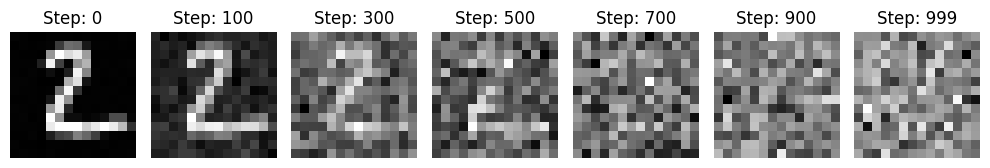

In [15]:
fig, ax = plt.subplots(1, len(record_steps), figsize=(10, 3))
for i, img in enumerate(forward_process):
    img = img.reshape(14,14,1)
    ax[i].imshow((img + 1) / 2, cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f"Step: {record_steps[i]}")
plt.tight_layout()
plt.show()

100%|██████████| 800/800 [00:19<00:00, 40.46it/s]


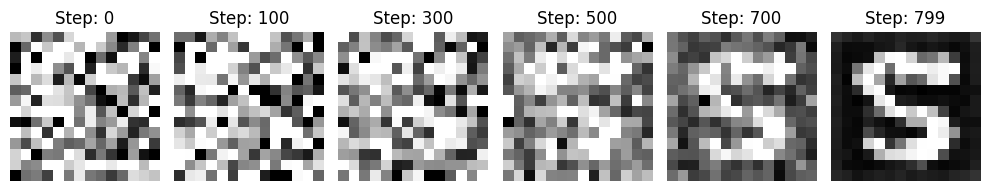

In [ ]:
model = Model()
model.load_state_dict(hcrot.utils.load('datasets/artifact.pkl'))

scheulder = layers.DDPMScheduler(beta_schedule="squaredcos_cap_v2", num_train_timesteps=1000)
scheulder.set_timesteps(num_inference_steps=800)
record_steps = [0, 100, 300, 500, 700, 799]

def inference(label, record_steps):
    latents = np.random.randn(1,1,14,14)
    label = np.array([i])

    reverse_process = []
    for t in tqdm(scheulder.timesteps):
        latent_model_input = scheulder.scale_model_input(latents, t)
        noise_pred = model(latent_model_input, t, label)
        latents = scheulder.step(noise_pred, t, latents).prev_sample

        if t in record_steps:
            image = (latents / 2 + 0.5).clip(0, 1)
            image = np.squeeze(image)
            reverse_process.append(image)
        
    return reverse_process

reverse_process = inference(5, record_steps)

fig, ax = plt.subplots(1, len(record_steps), figsize=(10, 3))
for i, img in enumerate(reverse_process):
    img = img.reshape(14,14,1)
    ax[i].imshow((img + 1) / 2, cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f"Step: {record_steps[i]}")
plt.tight_layout()
plt.show()

In [ ]:
model = Model()
model.load_state_dict(hcrot.utils.load('datasets/artifact.pkl'))

scheulder = layers.DDPMScheduler(beta_schedule="squaredcos_cap_v2", num_train_timesteps=1000)
scheulder.set_timesteps(num_inference_steps=800)

all_images = []
for i in range(10):
    latents = np.random.randn(1,1,14,14)
    label = np.array([i])

    for t in tqdm(scheulder.timesteps, desc=f"label_{i}"):
        latent_model_input = scheulder.scale_model_input(latents, t)
        noise_pred = model(latent_model_input, t, label)
        latents = scheulder.step(noise_pred, t, latents).prev_sample

    image = (latents / 2 + 0.5).clip(0, 1)
    image = np.squeeze(image)
    image = (image * 255).round().astype("uint8")
    all_images.append(image)

label_9: 100%|██████████| 800/800 [00:25<00:00, 30.93it/s]


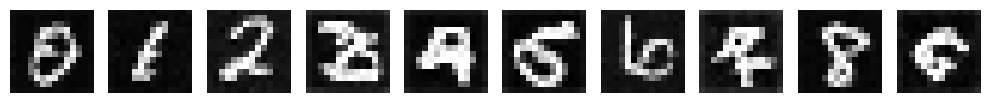

In [53]:
fig, axs = plt.subplots(1, 10, figsize=(10,10))
for i, img in enumerate(all_images):
    img = img.reshape(14,14,1)
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')
plt.tight_layout()
plt.show()